## **Plant Doctor**

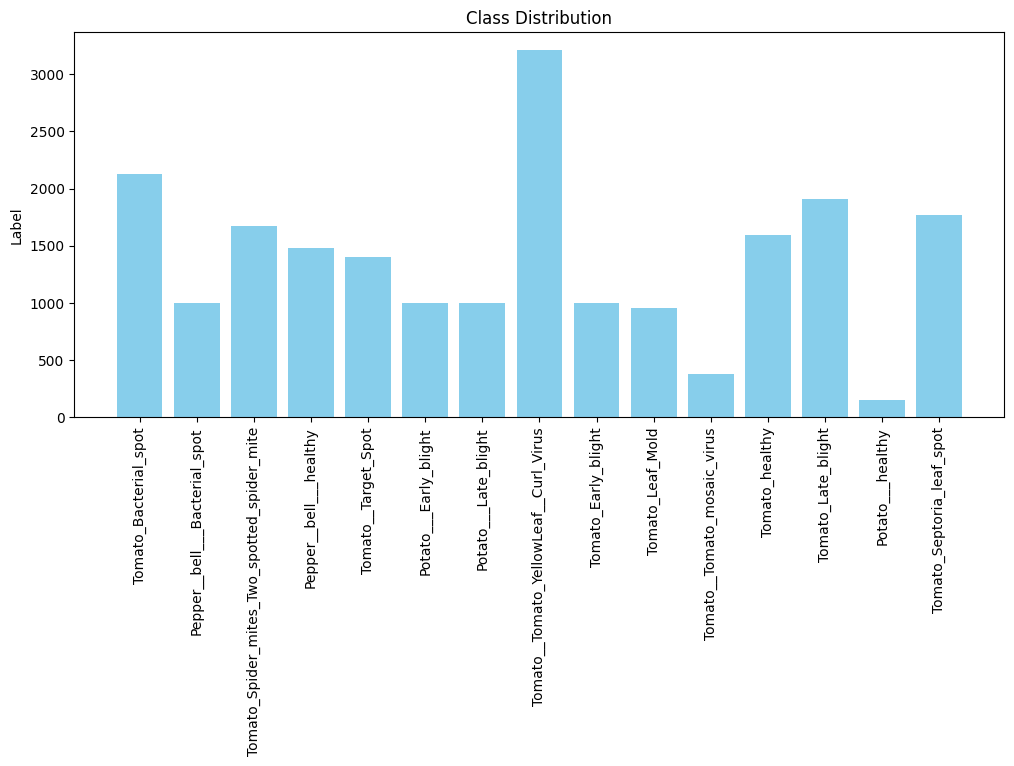

In [52]:
import os
import matplotlib.pyplot as plt
from pathlib import Path

path = Path("plantdisease/PlantVillage")

labels = os.listdir(path)
counts = [len(os.listdir(os.path.join(path, label))) for label in labels]

plt.figure(figsize=(12, 5))
plt.bar(labels, counts, color='skyblue')
plt.ylabel("Image count")
plt.ylabel("Label")
plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()

#### Data Loading

In [53]:
from sklearn.model_selection import train_test_split
import pandas as pd

def load_data(path):
    data = []
    
    for p in path.iterdir():
        for image in p.iterdir():
            if image.suffix.lower() == ".jpg":
                data.append((image, image.parents[0].stem))
    
    return pd.DataFrame(data, columns=['path', 'label'])

df = load_data(path)

train_df, test_df = train_test_split(df, test_size=0.2)
train_df, valid_df = train_test_split(train_df, test_size=0.1)

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(14857, 2)
(1651, 2)
(4128, 2)


In [54]:
label_map = {label: i for i, label in enumerate(os.listdir(path))}
print(label_map)

{'Tomato_Bacterial_spot': 0, 'Pepper__bell___Bacterial_spot': 1, 'Tomato_Spider_mites_Two_spotted_spider_mite': 2, 'Pepper__bell___healthy': 3, 'Tomato__Target_Spot': 4, 'Potato___Early_blight': 5, 'Potato___Late_blight': 6, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 7, 'Tomato_Early_blight': 8, 'Tomato_Leaf_Mold': 9, 'Tomato__Tomato_mosaic_virus': 10, 'Tomato_healthy': 11, 'Tomato_Late_blight': 12, 'Potato___healthy': 13, 'Tomato_Septoria_leaf_spot': 14}


In [55]:
from torch.utils import data
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor


class Data(data.Dataset):
    def __init__(self, df, label_map, transforms=None):
        super().__init__()
        
        self.df = df

        self.label_map = label_map
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sample = self.df.iloc[index]
        img = pil_to_tensor(Image.open(sample.path)) / 255
        
        if self.transforms is not None:
            img = self.transforms(image=img)['image']
        
        return img, sample.label


train = Data(train_df, label_map)
valid = Data(valid_df, label_map)
test = Data(test_df, label_map)

#### Data Normalization

In [ ]:
import torch


def get_dataset_stats(ds):
    all_pixels = torch.cat([img.unsqueeze(0) for img, _ in ds], dim=0)    
    ds_mean = all_pixels.mean(dim=[0, 2, 3]) 
    ds_std = all_pixels.std(dim=[0, 2, 3])

    return list(ds_mean), list(ds_std)


mean, std = get_dataset_stats(train)
print(f'Dataset stats\n  mean:\t {mean}\n  std:\t {std}' )


Dataset stats
  mean:	 [tensor(0.4590), tensor(0.4752), tensor(0.4115)]
  std:	 [tensor(0.1929), tensor(0.1703), tensor(0.2072)]


#### Data Augmentation

In [60]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(),
    A.Affine(rotate=(-180,180), p=.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
    A.Normalize(
        mean=mean,
        std=std,
    ),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(64, 64),
    A.Normalize(
        mean=mean,
        std=std,
    ),
    ToTensorV2()
])

train = Data(train, label_map, train_transform)
valid = Data(valid, label_map, valid_transform)
test = Data(test, label_map)

In [ ]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader

# rebalance the classes
class_counts = train_df['label'].value_counts()
class_weights = 1.0 / class_counts
sample_weights = train_df['label'].map(class_weights).values

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_dataloader = DataLoader(train, batch_size=64, sampler=sampler)
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=64, shuffle=True)